# Source finding

## 1. Initialisation

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from time import time
from scipy import stats
import importlib
import scripts
importlib.reload(scripts)

scripts init
scripts init


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

## 2. Read data

In [2]:
importlib.reload(scripts.read_data)
object_name, data = scripts.read_data.run(21)

Read dataset 21: "CIG 335" (1000, 1000) (0.00415 s)


## 3. Sort data

In [3]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(data.ravel())

Sorted 1000000 finite measurements in ascending order (0.122 s)


## 4. Hierarchical Overdensity Tree (HOT)

In [4]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'    ({time()-t0:.3g} s)')

HOT: 160225 overdensities found, 1000000 "pixels" (100%), 1 independent regions
    (3.05 s)


In [5]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]

## 5. Selection criterion

### estimate variance:

In [6]:
z_Chernoff_max = 1 + np.logspace(-3, 3, 101)
n_Chernoff_max = 1 - 2*np.log(1/test_stat.size)/(z_Chernoff_max-1-np.log(z_Chernoff_max))
z_Chernoff_min = np.logspace(-12, -.01, 101)
n_Chernoff_min = 1 - 2*np.log(1/test_stat.size)/(z_Chernoff_min-1-np.log(z_Chernoff_min))

In [7]:
a_mid = np.unique(area)[2:-1]
bound = np.inf
variance_estimate = np.nan
for a in a_mid[-100::-1]:
    a_Chernoff_max = np.interp(a, n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1])
    t_median = np.median(test_stat[area>a])
    variance_estimate = t_median*a/(a-1)/(1-2/9/(a-1.)**3)
    new_bound = variance_estimate*10**a_Chernoff_max
    #print(new_bound)
    if new_bound < bound:
        bound = new_bound
        variance_median = variance_estimate
    else:
        if new_bound > 2*bound:
            break

#t_mean = np.array([np.mean(test_stat[area>a_mid[i]]) for i in range(a_mid.size)])
#t_mean_low = np.array([np.mean(test_stat[(area>1) & (area<=a_mid[i])]) for i in range(a_mid.size)])


In [8]:
variance_estimate, variance_median

(4.683648142025343e-07, 6.1503536503335e-07)

In [9]:
p_value = 1 - stats.chi2.cdf(test_stat*area/variance_median, df=area-1)

In [10]:
interp_log_Chernoff_max = np.interp(area, n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1])
reliable_overdensity = (area > 1) & (test_stat > variance_median*10**interp_log_Chernoff_max)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.7105261433665853e-07


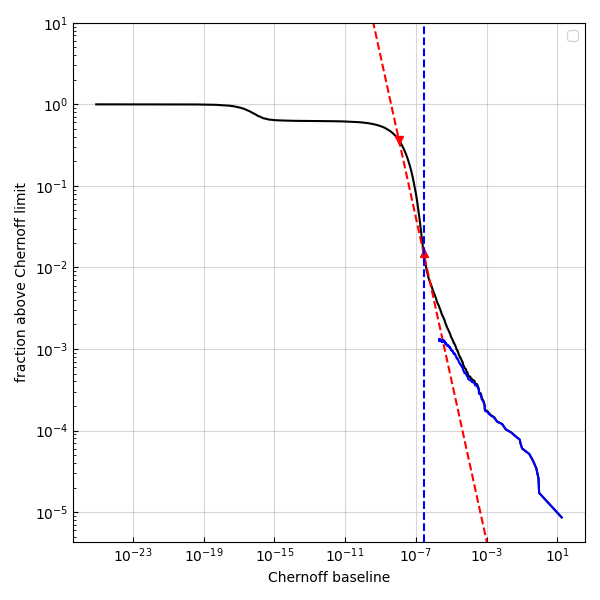

In [11]:
plt.close('test')
fig = plt.figure('test', figsize=(6, 6))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]
ax.set_ylabel('fraction above Chernoff limit')
ax.set_xlabel('Chernoff baseline')
ax.set_xscale('log')
ax.set_yscale('log')

x = np.sort(test_stat/10**interp_log_Chernoff_max)
x = x[x > 0]
n = (x.size-np.arange(x.size))/x.size
x_median = x[x.size//2]
x_cut = x[np.argmax(1-x/x[-1] - n)]
n_cut = n[np.argmax(1-x/x[-1] - n)]
ax.plot(x, n, 'k-')

'''
y = n*(x/x[x.size//2])**.1
index_0 = np.argmax(y)
t_0 = x[index_0]
n_0 = n[index_0]
ax.plot(x, y, 'b:', alpha=.25)
ax.axvline(t_0, c='b', ls=':')
y = n*(x/x[x.size//2])
index_1 = np.argmin(y[index_0:])
t_1 = x[index_0:][index_1]
n_1 = n[index_0:][index_1]
ax.plot(x, y, 'b--', alpha=.25)
ax.axvline(t_1, c='b', ls='--')
ax.plot(x[index_0:], n_0*pow(n_1/n_0, (x[index_0:]-t_0)/(t_1-t_0)), 'r-', label='contamination')
'''

'''
slope_0 = -np.log(n/n[-1])/np.log(x/x[-1])
index_0 = np.argmax(slope_0[:-1])
ax.plot(x, slope_0, 'b:', alpha=.25)
t_0 = x[index_0]
n_0 = n[index_0]
ax.plot(t_0, n_0, 'bo')
ax.axvline(x[x.size//2], c='b', ls=':')
'''

index_0 = x.size//2
index_1 = x.size
t = x[index_0:index_1]
n_t = n[index_0:index_1]
#ax.plot(t[0], n_t[0], 'bv')
#ax.plot(t[-1], n_t[-1], 'b^')
slope_0 = np.log(n_t[-1]/n_t[0]) / np.log(t[-1]/t[0])
power_law = n_t[0] * pow((t/t[0]), slope_0)
#ax.plot(t, power_law, 'b--')

difference = power_law-n_t
#ax.plot(t, difference, 'r-')
#ax.plot(t, -difference, 'r--')
index_0 = np.argmin(difference)
index_1 = np.argmax(difference)
t = t[index_0:index_1]
n_t = n_t[index_0:index_1]
ax.plot(t[0], n_t[0], 'rv')
ax.plot(t[-1], n_t[-1], 'r^')
slope_0 = np.log(n_t[-1]/n_t[0]) / np.log(t[-1]/t[0])
power_law = n_t[0] * pow((x/t[0]), slope_0)
ax.plot(x, power_law, 'r--')

power_law = n_t[0] * pow((t/t[0]), slope_0)
Chernoff_threshold = np.max(t[power_law > n_t])

print(t[-1])
n_t = n[x > t[-1]]
t = x[x > t[-1]]
power_law = n_t[0] * pow((t/t[0]), slope_0)
n_t -= power_law
index_0 = np.argmax(n_t)
n_t = n_t[index_0:]
t = t[index_0:]
ax.plot(t, n_t, 'b-')
#Chernoff_threshold = t[0]
ax.axvline(Chernoff_threshold, c='b', ls='--')

'''
index_1 =
slope_2 = np.log(n/n[-1])/np.log(x/x[-1])
'''
'''
y = n*(x/x[x.size//2])
ax.plot(x, y, 'b--', alpha=.25)
y = 1-x/x[-1] -n
ax.plot(x, y, 'b--', alpha=.25)
index_1 = np.argmax(y)
t_1 = x[index_1]
n_1 = n[index_1]
ax.axvline(t_1, c='b', ls=':')
n_0 = .5
t_0 = x[x.size//2]
y = np.log(n_1/n_0)/np.log(t_1/t_0)
ax.plot(x, n_0*pow((x/t_0), y), 'r-', label='contamination')
y = n*(x/x[x.size//2])*np.exp(-x/x[x.size//2])
ax.plot(x, y, 'r:')
'''
'''
t0 = x[x.size//2]
s0 = x[-1]
n0 = 1
t1 = x[-1]
s1 = x[-1]
n1 = 1
print(t0, t1)
w0 = n0*np.exp(-.5*((x-t0)/s0)**2)
w1 = n1*np.exp(-.5*((x-t1)/s1)**2)
w0 /= (w0+w1)
w1 = 1-w0
n0 = np.sum(w0)
n1 = np.sum(w1)
t0 = np.sum(x*w0)/n0
t1 = np.sum(x*w1)/n1
print(t0, t1, n0, n1)
w0 = n0*np.exp(-.5*((x-t0)/s0)**2)
w1 = n1*np.exp(-.5*((x-t1)/s1)**2)
w0 /= (w0+w1)
w1 = 1-w0
n0 = np.sum(w0)
n1 = np.sum(w1)
t0 = np.sum(x*w0)/n0
t1 = np.sum(x*w1)/n1
print(t0, t1, n0, n1)
w0 = n0*np.exp(-.5*((x-t0)/s0)**2)
w1 = n1*np.exp(-.5*((x-t1)/s1)**2)
w0 /= (w0+w1)
w1 = 1-w0
n0 = np.sum(w0)
n1 = np.sum(w1)
t0 = np.sum(x*w0)/n0
t1 = np.sum(x*w1)/n1
print(t0, t1, n0, n1)
w0 = n0*np.exp(-.5*((x-t0)/s0)**2)
w1 = n1*np.exp(-.5*((x-t1)/s1)**2)
w0 /= (w0+w1)
w1 = 1-w0
n0 = np.sum(w0)
n1 = np.sum(w1)
t0 = np.sum(x*w0)/n0
t1 = np.sum(x*w1)/n1
print(t0, t1, n0, n1)
'''

ax.set_ylim(.5/x.size, 1e1)
ax.legend()

for ax in axes.flatten():
    ax.tick_params(which='both', direction='in')
    ax.grid(alpha=.5)
fig.set_tight_layout(True)
plt.show()

In [12]:
reliable_overdensity = test_stat > Chernoff_threshold * 10**interp_log_Chernoff_max
n_reliable = np.count_nonzero(reliable_overdensity)
print(n_reliable)

1762


In [13]:
plots = True
data_dimensionality = sorted_strides.size-1

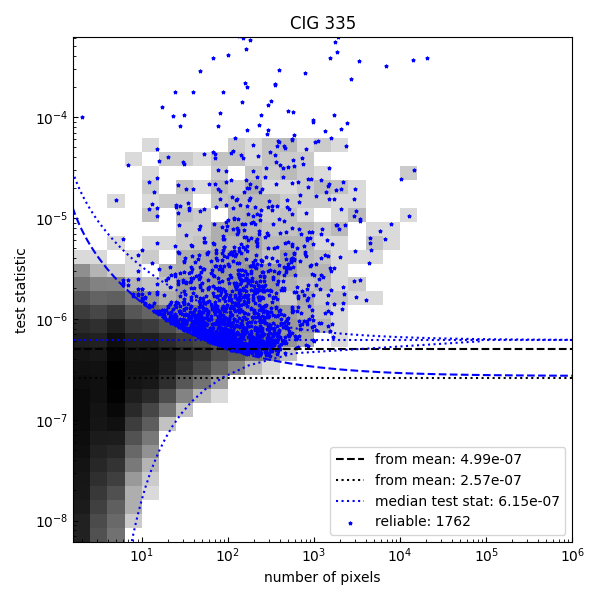

In [14]:
if plots:
    plt.close('catalogue_selection')
    fig = plt.figure('catalogue_selection', figsize=(6, 6))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        #axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('test statistic')

    #ax[0, 0].scatter(area, test_stat, s=25, c='c', alpha=.1)
    h2d = ax[0, 0].hist2d(area[p_value<1.5], test_stat[p_value<1.5],
                          bins=[np.logspace(0.2, np.log10(data.size), 30),
                                np.logspace(np.log10(1e-2*variance_median), np.log10(1e2*variance_median), 30)],
                          cmap='Greys', norm=colors.SymLogNorm(linthresh=1))
    good = np.where((area > 1) & (test_stat > 0))
    variance_from_mean = np.mean(np.sqrt(test_stat[good]*(1+1/area[good])))**2
    variance_from_median = np.median(test_stat[good]*(1+1/area[good]))
    ax[0, 0].axhline(variance_from_mean, c='k', ls='--', label=f'from mean: {variance_from_mean:.3g}')
    ax[0, 0].axhline(variance_from_median, c='k', ls=':', label=f'from mean: {variance_from_median:.3g}')
    ax[0, 0].axhline(variance_median, c='b', ls=':', label=f'median test stat: {variance_median:.3g}')
    #ax[0, 0].axhline(Chernoff_variance, c='b', ls='--')
    ax[0, 0].plot(n_Chernoff_max, Chernoff_threshold*z_Chernoff_max, 'b--')
    ax[0, 0].plot(n_Chernoff_max, x_cut*z_Chernoff_max, 'k--')
    ax[0, 0].plot(n_Chernoff_max, variance_median*z_Chernoff_max, 'b:')
    ax[0, 0].plot(n_Chernoff_min, variance_median*z_Chernoff_min, 'b:')
    #bins_area = np.logspace(0, np.log10(data.size))
    #bins_test_stat = np.linspace(*np.nanpercentile(test_stat, [1, 99]))
    #ax[0, 0].hist2d(area, test_stat, bins=[bins_area, bins_test_stat], cmap='nipy_spectral', vmin=1, vmax=3)

    #ax[0, 0].scatter(area[~possible_overdensity], -test_stat[~possible_overdensity], s=10, c='r', alpha=.25)
    #ax[0, 0].scatter(area[possible_overdensity], test_stat[possible_overdensity], s=1, c='k', label=f'possible: {n_possible}')
    ax[0, 0].scatter(area[reliable_overdensity], test_stat[reliable_overdensity], s=5, c='b', marker='*', label=f'reliable: {n_reliable}')

    #ax[0, 0].axvline(a_cut, c='b', ls=':', label=f'a_cut: {a_cut:.3g}')
    #ax[0, 0].plot(a_mid, t_mean, 'k-')
    #ax[0, 0].plot(a_mid, t_median, 'k--')
    #ax[0, 0].plot(a_mid, t_mean_low, 'k:')
    #ax[0, 0].plot(a_mid, variance_estimate, 'g-')
    #ax[0, 0].plot(a_mid, variance_estimate*10**a_Chernoff_max, 'g-')

    #ax[0, 0].axvline(area_threshold_min, c='k', ls=':', label=f'area > {area_threshold_min}')
    #ax[0, 0].axhline(test_stat_threshold_min, c='k', ls=':', label=f'test statistic > {test_stat_threshold_min:.2f}')
    #ax[0, 0].axvline(area_threshold_max, c='k', ls='--', label=f'area > {area_threshold_max}')
    #ax[0, 0].axhline(test_stat_threshold_max, c='k', ls='--', label=f'test statistic > {test_stat_threshold_max:.2f}')

    ax[0, 0].set_ylim(1e-2*variance_median, 1e3*variance_median)
    #ax[0, 0].set_xlim(.5, 3e3)
    #ax[0, 0].set_ylim(-15, 45)
    #ax[0, 0].set_yscale('symlog')
    ax[0, 0].set_yscale('log')
    ax[0, 0].legend()

    
    '''
    ax[1, 0].set_ylabel('p-value')
    ax[1, 0].set_yscale('log')
    #ax[1, 0].set_ylim(.1/test_stat.size)
    ax[1, 0].scatter(area, p_value, s=25, c='c', alpha=.1)
    ax[1, 0].plot(a_pvalue, 1/n_pvalue, 'k--', label='1/n_larger')
    ax[1, 0].scatter(area[reliable_overdensity], p_value[reliable_overdensity], s=5, c='b', marker='*', label=f'reliable: {n_reliable}')
    ax[1, 0].legend()
    ax[1, 0].set_ylim(1e-3, 2)

    ax[2, 0].scatter(area, test_stat_Chernoff, s=25, c='c', alpha=.1)
    ax[2, 0].scatter(area[reliable_overdensity], test_stat_Chernoff[reliable_overdensity], s=5, c='b', marker='*', label=f'reliable: {n_reliable}')
    ax[2, 0].axhline(np.log10(variance_median/variance_cut), c='b', ls=':')
    ax[2, 0].set_ylim(-2, 2)
    '''
    
    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('number of pixels')
    plt.show()

In [15]:
#true_overdensity = (area > 30) & (test_stat > 1)
#true_ovn_reliableensity = possible_overdensity
true_overdensity = reliable_overdensity

## 8. Clean-up

### prune HOT based on selection threshold

In [16]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0

158464 yet to go
78866 yet to go
18319 yet to go
1554 yet to go
36 yet to go
1 yet to go


### rename labels and create final catalogues

In [17]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

1763 objects after mode filtering


In [18]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [19]:
if plots and data_dimensionality == 2:
    from photutils import segmentation as segm
    if n_reliable > 0:
        final_selection = segm.SegmentationImage(final_labels)
        final_cmap = final_selection.make_cmap(seed=123)
        final_catalog = segm.SourceCatalog(data, final_selection)
        final_catalog.to_table()
    else:
        final_selection = final_labels
        final_cmap = 'viridis'

    p0, p50, p100 = np.nanpercentile(data, [0, 50, 100])
    colour_scale = colors.SymLogNorm(vmin=p0, linthresh= 2*p50-p0, vmax=p100)


/tmp/ipykernel_40829/2661266834.py:57: RuntimeWarning: divide by zero encountered in log10
  np.log10(test_stat[label]/Chernoff_threshold),
/tmp/ipykernel_40829/2661266834.py:57: RuntimeWarning: invalid value encountered in log10
  np.log10(test_stat[label]/Chernoff_threshold),


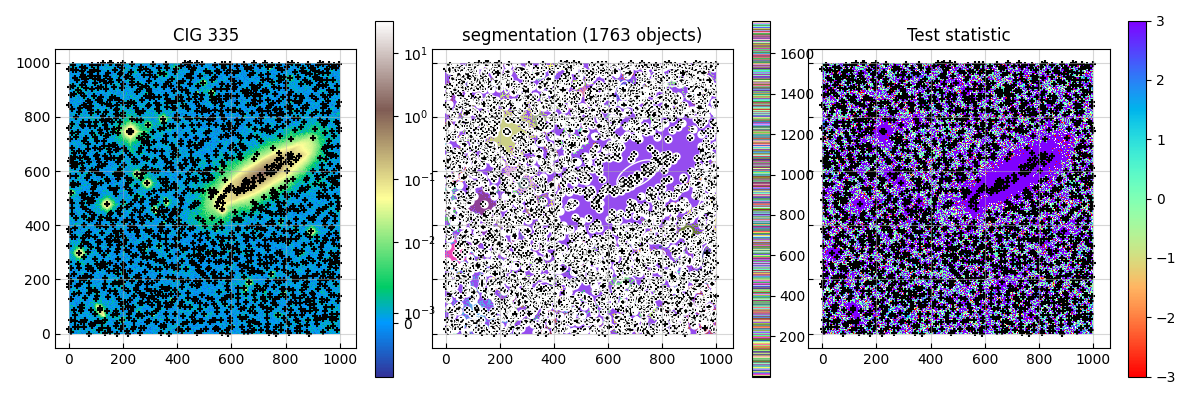

In [20]:
if plots and data_dimensionality == 2:
    plt.close('segmentation')
    fig = plt.figure('segmentation', figsize=(12, 4))
    ax = fig.subplots(nrows=1, ncols=3, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
#        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    #ax[0, 0].contour(final_labels, levels=[0.5], colors=['k'])
    #ax[0, 0].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    #cb.ax.axhline(mode, c='k', ls=':')
    #cb.ax.axhline(data.threshold, c='w', ls='--')
    #cb.ax.axhline(2*mode-data.threshold, c='w', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='w')
    #ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
    if n_reliable > 0:
        ax[0, 0].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='k', marker='+')

    '''
    ax[0, 1].set_title('Smoothed data')
    im = ax[0, 1].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 1].contour(final_labels, levels=[0.5])
    #ax[0, 1].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(smoothed_mode, c='k', ls=':')
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')
    '''
    ax[0, 1].set_title(f'segmentation ({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    if n_reliable > 0:
        ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
        ax[0, 1].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='k', marker='+')
        final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')
    cb = fig.colorbar(im, ax=ax[0, 1])

    axis = ax[0, 2]
    axis.set_title('Test statistic')
    im = axis.imshow(
        np.log10(test_stat[label]/Chernoff_threshold),
        interpolation='nearest', origin='lower', cmap='rainbow_r',
        vmin=-3, vmax=3,
        )
    cb = fig.colorbar(im, ax=axis)
    if n_reliable > 0:
        ax[0, 2].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='k', marker='+')

    '''
    axis = ax[0, 3]
    axis.set_title('p_value')
    im = axis.imshow(
        test_stat_Chernoff[label],
        interpolation='nearest', origin='lower', cmap='rainbow',
        #vmin = 0, vmax = test_stat_threshold_max,
        )
    cb = fig.colorbar(im, ax=axis)
    '''


In [21]:
if plots and data_dimensionality == 3:

    mode = 0
    
    max_map = np.nanmax(final_labels, axis=0)
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    ax[0, 0].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    ax[0, 1].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [22]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.nansum(section_labels**2, axis=2).T / (np.nansum(section_labels, axis=2).T + 1e-300)
    horizontal_slit = np.nansum(section_labels**2, axis=1).T / (np.nansum(section_labels, axis=1).T + 1e-300)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [23]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


NameError: name 'fits' is not defined

In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
